# # Intro to AI
# Fast Trajectory Planning (Assignment - 1)
# Sai Mounica Pothuru (sp1912)
# Chaitanya Sharma Domudala (cd817)
##

In [1]:
#Imports to use various function of python

from flask import Flask
import os
import time
import math
import heapq
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# Defining a class named Node to assign values to each cell in the maze.

class Node:
    def __init__(self, coordinates, parent, gvalue, hvalue):
        self.coordinates = coordinates
        self.parent = parent
        self.gvalue = gvalue
        self.hvalue = hvalue
        self.fvalue = self.gvalue + self.hvalue


    def __lt__(self, other):
        return self.fvalue < other.fvalue or (self.fvalue == other.fvalue and self.gvalue < other.gvalue) 
    # returns True or False based on the condition

In [3]:
# Defining what the A* method should do- More like computing the path in which the agent should move
# An open and closed list is available to keep a track of nodes that should be explored and that needs to be explored respectively
# Get the neighbors of the maze to check if they are in open or closed lists. Modify the f - value accordingly and explore
def AStar(maze, beginningCoordinates, endingCoordinates, sizeOfGrid, numberOfExpandedNodes):
    openList = []  # heap
    closedList = []
    numberOfExpandedNodes = 0
    beginningNode = Node(beginningCoordinates, None, 0, getheuristic(beginningCoordinates, endingCoordinates))
    openList.append(beginningNode)

    while openList[0].coordinates != endingCoordinates:  # while first priority node isnt the goal node
        poppedNode = heapq.heappop(openList)  # remove first priority from open list and add to closed list and expand it
        closedList.append(poppedNode)
        # expand the popped node
        potentialCoordinates = []
        potentialCoordinates.append(getleftCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getrightCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getupCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getdownCoordinates(poppedNode.coordinates))
        for coordinate in potentialCoordinates:
            if isValid(coordinate, maze, sizeOfGrid):
                # if the neighbor has valid coordinates and is not in closed list or in the open list, add that node in the open list
                if not (isClosed(coordinate, closedList)) and isOpen(coordinate, openList) == -1:
                    heapq.heappush(openList, Node(coordinate, poppedNode, poppedNode.gvalue + 1,getheuristic(coordinate, endingCoordinates)))
                    numberOfExpandedNodes = numberOfExpandedNodes + 1
                # if the neighbor has valid cooridnates and is not in closed list but is in open list
                elif not (isClosed(coordinate, closedList)) and isOpen(coordinate, openList) != -1:
                    # check if current distance can be improved
                    if openList[isOpen(coordinate, openList)].fvalue > (poppedNode.gvalue + 1 + getheuristic(coordinate, endingCoordinates)):
                        # change fvalue, g value, h value, change parent
                        openList[isOpen(coordinate, openList)].gvalue = poppedNode.gvalue + 1
                        openList[isOpen(coordinate, openList)].hvalue = getheuristic(coordinate,endingCoordinates)
                        openList[isOpen(coordinate, openList)].fvalue = poppedNode.gvalue + 1 + getheuristic(coordinate, endingCoordinates)
                        openList[isOpen(coordinate, openList)].parent = poppedNode
        # In case, the neighbors of the node are not valid coordinates (all are blocked)
        if len(openList) == 0:
            return [], numberOfExpandedNodes

    plannedPath = []
    goalNode = heapq.heappop(openList)
    currentNode = goalNode
    while currentNode != None:
        plannedPath.append(currentNode.coordinates)
        currentNode = currentNode.parent
    # The obtained path is from target to agent. So reverse it and return
    plannedPath.reverse()
    return plannedPath, numberOfExpandedNodes

# Define repeatedAStar for execution. Move the agent in the computed path and check if there are any obstacles
# If there are obstacles, find the path from obstacle point to goal node. REpeat the process until an obstacle free path is obtained.

def repeatedAStar(knowledgeMaze, trueMaze, beginningCoordinates, endingCoordinates, sizeOfGrid):
    plannedPaths = []
    knowledgeMazes = []
    numberOfExpandedNodes = 0
    totalNumberExpanded=0
    currentKnowledgeMaze = knowledgeMaze
    beginning = beginningCoordinates
    ending = endingCoordinates
    while True:
        # planning
        knowledgeMazes.append(currentKnowledgeMaze)
        currentPath,numberOfExpandedNodes = AStar(currentKnowledgeMaze, beginning, ending, sizeOfGrid, numberOfExpandedNodes)
        totalNumberExpanded = totalNumberExpanded + numberOfExpandedNodes

        plannedPaths.append(currentPath)
        if currentPath == []:
            return [plannedPaths, knowledgeMazes], totalNumberExpanded
        # execute
        # step through planned path
        # if current node is actually an obstacle, stop there and save the previous coordinate as the beginning coordinate for next iteration
        # if current node is the end node, stop there and return all needed info
        # otherwise, look at neighbors of the current node and see if they are obstacles in true maze. if so, plot these obstacles in the knowledge maze and insert updated knowledge maze

        currentKnowledgeMaze = np.copy(knowledgeMazes[-1])
        for index, w in enumerate(currentPath):
            if trueMaze[w[0]][w[1]] == 1:
                # update beginning to coordinates right before obstacle bump
                beginning = currentPath[index - 1]
                break
            if w == endingCoordinates:  # if the path executed actually makes it to the end, we're done
                return [plannedPaths, knowledgeMazes],totalNumberExpanded
            neighbors = []  # generate all neighbors
            currentCoordinate = currentPath[index]
            neighbors.append(getleftCoordinates(currentCoordinate))
            neighbors.append(getrightCoordinates(currentCoordinate))
            neighbors.append(getupCoordinates(currentCoordinate))
            neighbors.append(getdownCoordinates(currentCoordinate))
            # check if each neighbor is valid and is an obstacle --> if it is, update the knowledge maze
            for neighbor in neighbors:
                if isValid_2(neighbor, sizeOfGrid) and trueMaze[neighbor[0]][neighbor[1]] == 1:
                    currentKnowledgeMaze[neighbor[0]][neighbor[1]] = 1


# Definition to get the neighbors of the nodes. x and y coordinates of left, right, up and bottom of current node/coordinates

def getleftCoordinates(currentCoordinates):
    return (currentCoordinates[0] - 1, currentCoordinates[1])

def getrightCoordinates(currentCoordinates):
    return (currentCoordinates[0] + 1, currentCoordinates[1])

def getupCoordinates(currentCoordinates):
    return (currentCoordinates[0], currentCoordinates[1] + 1)

def getdownCoordinates(currentCoordinates):
    return (currentCoordinates[0], currentCoordinates[1] - 1)

# Heuristic value is the Manhattan distance in case of AStar
def getheuristic(currentCoordinates, endingCoordinates):
    return abs(endingCoordinates[0] - currentCoordinates[0]) + abs(endingCoordinates[1] - currentCoordinates[1])

# Define to check whether the neighbors are valid coordinates
def isValid(currentCoordinates, maze, sizeOfGrid):
    return 0 <= currentCoordinates[0] <= sizeOfGrid - 1 and 0 <= currentCoordinates[1] <= sizeOfGrid - 1 and \
           maze[currentCoordinates[0]][currentCoordinates[1]] != 1

# Definition to check the closed nodes
def isClosed(currentCoordinates, closedList):
    for node in closedList:
        if node.coordinates == currentCoordinates:
            return True

    return False

# Definition to check the open nodes
def isOpen(currentCoordinates, openList):
    for index, w in enumerate(openList):
        if w.coordinates == currentCoordinates:
            return index

    return -1





In [4]:
# Define Adaptive A* 
def AdaptiveAStar(maze, beginningCoordinates, endingCoordinates, sizeOfGrid, prevClosedList, goalDistance):
    openList = []  # heap
    closedList = []
    numberOfExpandedNodes = 0

    for index, w in enumerate(prevClosedList):
        w.hvalue = goalDistance - prevClosedList[index].gvalue

    beginningNode = Node(beginningCoordinates, None, 0, getheuristic(beginningCoordinates, endingCoordinates))
    if (isPrevClosed(beginningCoordinates, prevClosedList) != -1):
        openList.append(Node(beginningCoordinates, None, 0, prevClosedList[isPrevClosed(beginningCoordinates, prevClosedList)].hvalue))
    else:
        openList.append(beginningNode)
    while openList[0].coordinates != endingCoordinates:  # while first priority node isnt the goal node
        poppedNode = heapq.heappop(openList)  # remove first priority from open list and add to closed list and expand it
        numberOfExpandedNodes = numberOfExpandedNodes + 1
        closedList.append(poppedNode)
        # expand the popped node
        potentialCoordinates = []
        potentialCoordinates.append(getleftCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getrightCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getupCoordinates(poppedNode.coordinates))
        potentialCoordinates.append(getdownCoordinates(poppedNode.coordinates))
        for coordinate in potentialCoordinates:
            prevClosedIndex = isPrevClosed(coordinate, prevClosedList)
            if isValid(coordinate, maze, sizeOfGrid):
                # if the neighbor has valid coordinates and is not in closed list or in the open list, add that node in the open list
                if not (isClosed(coordinate, closedList)) and isOpen(coordinate, openList) == -1:
                    # If the node is in previous closed list, take the previous h-value , else compute the Manhattan distance
                    if (prevClosedIndex != -1):
                        heapq.heappush(openList, Node(coordinate, poppedNode, poppedNode.gvalue + 1, prevClosedList[prevClosedIndex].hvalue))
                    else:
                        heapq.heappush(openList, Node(coordinate, poppedNode, poppedNode.gvalue + 1, getheuristic(coordinate, endingCoordinates)))

                # if the neighbor has valid cooridnates and is not in closed list but is in open list
                elif not (isClosed(coordinate, closedList)) and isOpen(coordinate, openList) != -1:
                    # check if current distance can be improved
                    if (prevClosedIndex != -1):
                        if openList[isOpen(coordinate, openList)].fvalue > (poppedNode.gvalue + 1 + prevClosedList[prevClosedIndex].hvalue):
                            openList[isOpen(coordinate, openList)].gvalue = poppedNode.gvalue + 1
                            openList[isOpen(coordinate, openList)].hvalue = prevClosedList[prevClosedIndex].hvalue
                            openList[isOpen(coordinate, openList)].fvalue = prevClosedList[prevClosedIndex].hvalue + poppedNode.gvalue + 1
                            openList[isOpen(coordinate, openList)].parent = poppedNode
                    elif openList[isOpen(coordinate, openList)].fvalue > (poppedNode.gvalue + 1 + getheuristic(coordinate, endingCoordinates)):
                        # change fvalue, g value, h value, change parent
                        openList[isOpen(coordinate, openList)].gvalue = poppedNode.gvalue + 1
                        openList[isOpen(coordinate, openList)].hvalue = getheuristic(coordinate,endingCoordinates)
                        openList[isOpen(coordinate, openList)].fvalue = poppedNode.gvalue + 1 + getheuristic(coordinate, endingCoordinates)
                        openList[isOpen(coordinate, openList)].parent = poppedNode
        # Invalid neighbors case
        if len(openList) == 0:
            return [], numberOfExpandedNodes,closedList,0

    plannedPath = []
    goalNode = heapq.heappop(openList)
    currentNode = goalNode
    while currentNode != None:
        plannedPath.append(currentNode.coordinates)
        currentNode = currentNode.parent
    # return planned path
    plannedPath.reverse()
    return plannedPath, numberOfExpandedNodes, closedList, (len(plannedPath) - 1)

# Define repeated A * method to make the Agent follow the path computed.
# Incase of obstacles, get the previous coordinate and compute the path again to the target and then explore

def repeatedAdaptiveAStar(knowledgeMaze, trueMaze, beginningCoordinates, endingCoordinates, sizeOfGrid):
    plannedPaths = []
    knowledgeMazes = []
    totalNumberExpanded = 0
    closedList = []
    goalDistance = 0
    currentKnowledgeMaze = knowledgeMaze
    beginning = beginningCoordinates
    ending = endingCoordinates
    while True:
        # planning
        knowledgeMazes.append(currentKnowledgeMaze)
        currentPath, numberOfExpandedNodes, closedList, goalDistance = AdaptiveAStar(currentKnowledgeMaze,beginning, ending,sizeOfGrid, closedList, goalDistance)
        #print("Goal distance: ", goalDistance)
        totalNumberExpanded = totalNumberExpanded + numberOfExpandedNodes

        plannedPaths.append(currentPath)
        if currentPath == []:
            return [[], knowledgeMazes]  # , totalNumberExpanded
        # execute
        # step through planned path
        # if current node is actually an obstacle, stop there and save that coordinate as the beginning coordinate for next iteration
        # if current node is the end node, stop there and return all needed info
        # otherwise, look at neighbors of the current node and see if they are obstacles in true maze. if so, plot these obstacles in the knowledge maze and insert updated knowledge maze
        currentKnowledgeMaze = np.copy(knowledgeMazes[-1])

        #print("path found")
        #print(currentPath)
        #print("number expanded nodes this iteration:")
        #print(numberOfExpandedNodes)
        #print()

        for index, w in enumerate(currentPath):
            if trueMaze[w[0]][w[1]] == 1:
                # update beginning to coordinates right before obstacle bump
                beginning = currentPath[index - 1]
                break
            if w == (endingCoordinates):  # if the path executed actually makes it to the end, we're done
                return [plannedPaths, knowledgeMazes], totalNumberExpanded
            neighbors = []  # generate all neighbors
            currentCoordinate = currentPath[index]
            neighbors.append(getleftCoordinates(currentCoordinate))
            neighbors.append(getrightCoordinates(currentCoordinate))
            neighbors.append(getupCoordinates(currentCoordinate))
            neighbors.append(getdownCoordinates(currentCoordinate))
            # check if each neighbor is valid and is an obstacle --> if it is, update the knowledge maze
            for neighbor in neighbors:
                if isValid_2(neighbor, sizeOfGrid) and trueMaze[neighbor[0]][neighbor[1]] == 1:
                    currentKnowledgeMaze[neighbor[0]][neighbor[1]] = 1  # without assigning 1, it is an infinite loop?



# Definition to check for the valid neighboring cocordinates
def isValid_2(currentCoordinates, sizeOfGrid):
    return 0 <= currentCoordinates[0] <= sizeOfGrid - 1 and 0 <= currentCoordinates[1] <= sizeOfGrid - 1

# CHeck if the node is already in previously closed list
def isPrevClosed(currentCoordinates, prevClosedList):
    for index, w in enumerate(prevClosedList):
        if w.coordinates == currentCoordinates:
            return index
    return -1


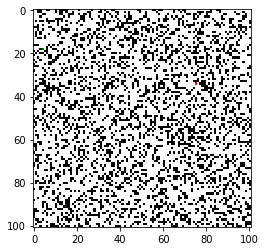

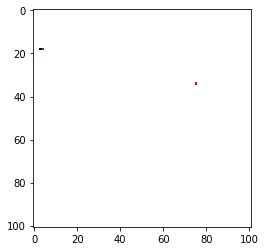

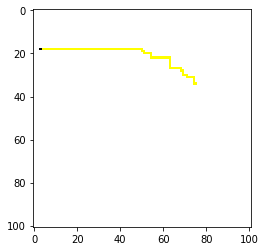

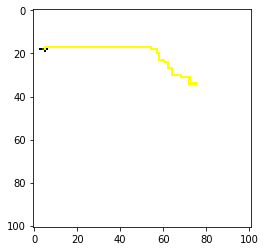

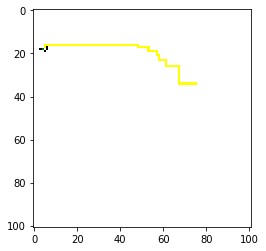

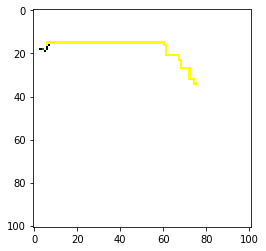

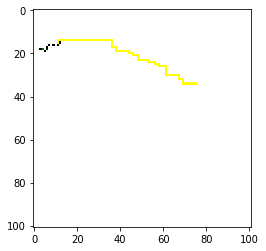

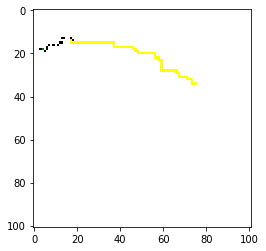

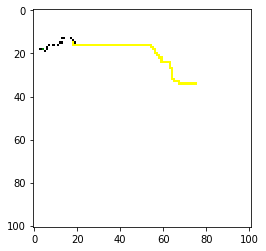

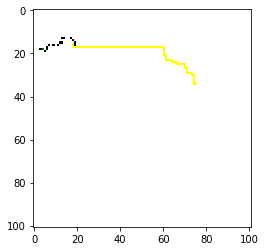

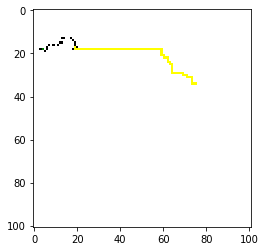

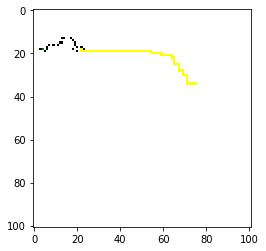

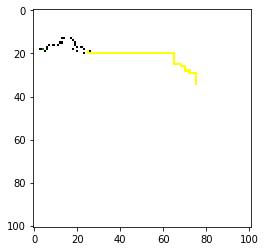

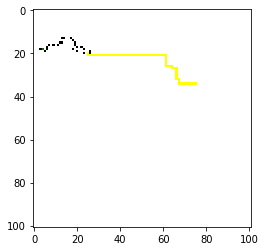

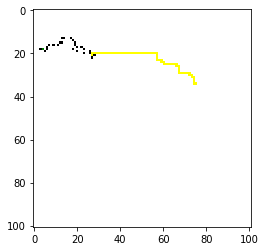

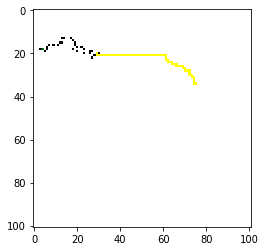

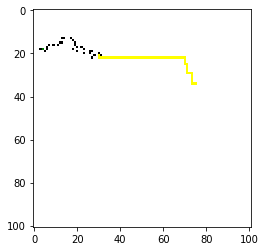

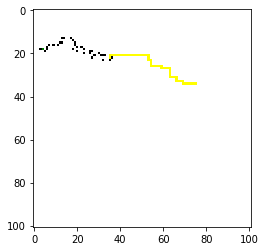

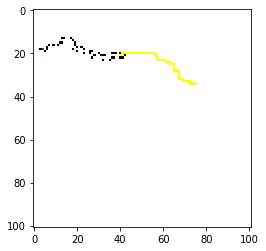

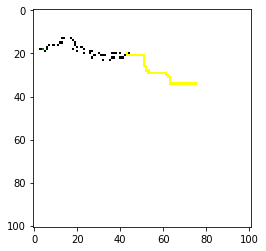

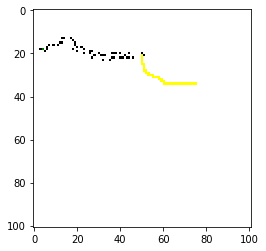

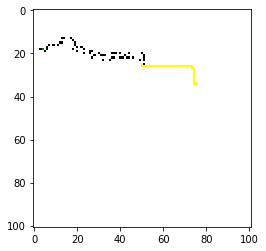

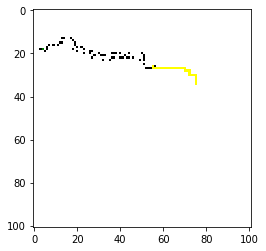

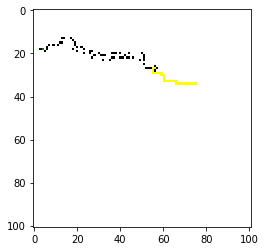

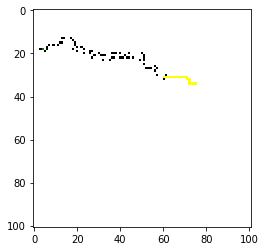

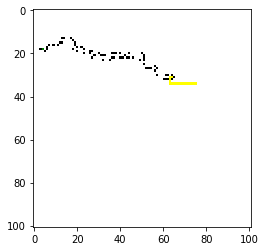

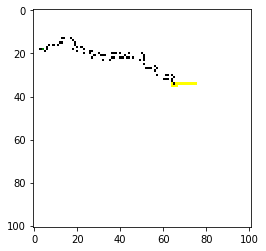

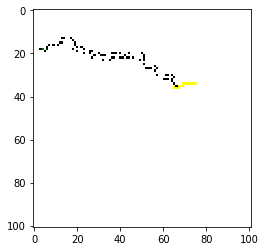

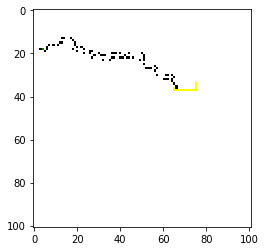

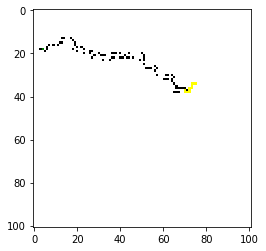

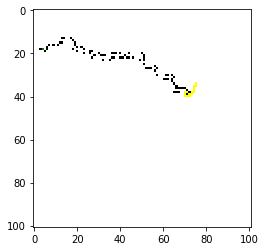

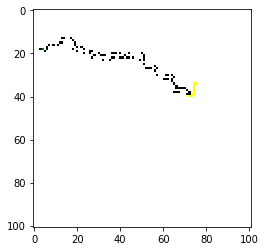

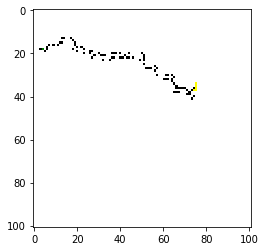

Total number of expanded Nodes in:  forwards   20921
Total time to reach goal state:  forwards   26.548335075378418


In [5]:
def tracePath(maze, path):
    for coordinate in path:
        maze[coordinate] = 5
    return maze


#### CONFIGURATION ####
# random.seed(122)
# np.set_printoptions(threshold=10)  # np.inf

color_set = ['white', 'black', 'green', 'red', 'yellow']
range_set = np.array([-0.5, 0.5, 2.5, 3.5, 4.5, 5.5])

cmap = colors.ListedColormap(color_set)
norm = colors.BoundaryNorm(range_set, len(color_set))

#### PARAMETERS #####
size = 101  # 25 #101
probability = 0.7
method = "backwards"#"adaptive"#"backwards"#

#for i in range(0,50):(loop for 50 iterations)
# create actual maze and knowledge maze
trueMaze = np.zeros(shape=(size, size)).astype(int)
knowledgeMaze = np.zeros(shape=(size, size)).astype(int)

# set start and end points
x_agent = random.randint(0, size - 1);
y_agent = random.randint(0, size - 1);

x_target = random.randint(0, size - 1);
y_target = random.randint(0, size - 1);

trueMaze[x_agent, y_agent] = 3
trueMaze[x_target, y_target] = 4

knowledgeMaze[x_agent, y_agent] = 3
knowledgeMaze[x_target, y_target] = 4

# populate actual maze
for x in np.nditer(trueMaze, op_flags=['readwrite']):
    if random.random() >= probability:
        if (x[...] != 3 and x[...] != 4):
            x[...] = 1
    else:
        if (x[...] != 3 and x[...] != 4):
            x[...] = 0


########## TESTING ##################

start_time = time.time()

if (method == "forwards"):
    # give knowledge maze initial knowledge
    if isValid_2([x_agent - 1, y_agent], size):
        if (trueMaze[x_agent - 1, y_agent]) == 1:
            knowledgeMaze[x_agent - 1, y_agent] = 1
    if isValid_2([x_agent + 1, y_agent], size):
        if trueMaze[x_agent + 1, y_agent] == 1:
            knowledgeMaze[x_agent + 1, y_agent] = 1
    if isValid_2([x_agent, y_agent - 1], size):
        if trueMaze[x_agent, y_agent - 1] == 1:
            knowledgeMaze[x_agent, y_agent - 1] = 1
    if isValid_2([x_agent, y_agent + 1], size):
        if trueMaze[x_agent, y_agent + 1] == 1:
            knowledgeMaze[x_agent, y_agent + 1] = 1
    path = repeatedAStar(knowledgeMaze, trueMaze, (x_agent, y_agent), (x_target, y_target), size)

elif (method == "backwards"):
    # trueMaze[0,0] = 4
    # trueMaze[size-1,size-1] = 3
    # knowledgeMaze[0,0] = 4
    # knowledgeMaze[size-1,size-1] = 3
    trueMaze[x_agent, y_agent] = 4
    trueMaze[x_target, y_target] = 3
    knowledgeMaze[x_target, y_target] = 3
    knowledgeMaze[x_agent, y_agent] = 4

    if isValid_2([x_target - 1, y_target], size):
        if (trueMaze[x_target - 1, y_target]) == 1:
            knowledgeMaze[x_target - 1, y_target] = 1
    if isValid_2([x_target + 1, y_target], size):
        if trueMaze[x_target + 1, y_target] == 1:
            knowledgeMaze[x_target + 1, y_target] = 1
    if isValid_2([x_target, y_target - 1], size):
        if trueMaze[x_target, y_target - 1] == 1:
            knowledgeMaze[x_target, y_target - 1] = 1
    if isValid_2([x_target, y_target + 1], size):
        if trueMaze[x_target, y_target + 1] == 1:
            knowledgeMaze[x_target, y_target + 1] = 1
    path = repeatedAStar(knowledgeMaze, trueMaze, (x_target, y_target), (x_agent, y_agent), size)

elif (method == "adaptive"):
    path = repeatedAdaptiveAStar(knowledgeMaze, trueMaze, (x_agent, y_agent), (x_target, y_target), size)

else:
    print("invalid option")

end_time = time.time()

plt.imshow(trueMaze, cmap=cmap, norm=norm)
plt.show()

plt.imshow(knowledgeMaze, cmap=cmap, norm=norm)
plt.show()

# DISPLAY PARTIAL PATHS

for index, partial in enumerate(path[0][0]):
    pathMaze = tracePath(path[0][1][index], partial)  # partial  color co-ordinates
    plt.imshow(pathMaze, cmap=cmap, norm=norm)
    plt.show()

print('Total number of expanded Nodes in: ', method, ' ', path[1])

final_time = time.time()

print('Total time to reach goal state: ', method, ' ', final_time - start_time)